In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GRU, SimpleRNN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [18]:
# Load CSV files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [19]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Using the texts in tweet, I have to predict whether a given tweet is realted to a real diasater (target = 1),
or not (target = 0). Building a machine learning which can do this work is very challenging because tweets
contain informal language, slang and ambiguous phrases. Therefore, my goal in this project is to use Natual Language Processing (NLP)
techniques to interpret these tweets and classify them accurately. 

First of all, let's check some basic information about the data sets.

In [21]:
#Checking basic information of train dataset
print("Row and column numbers", train.shape)
print('-------------------------------------------------------')

print(train.info())

Row and column numbers (7613, 5)
-------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


There are total 7613 rows in training data set. The 'id', 'text', and 'target' do not have any null value,
but 'keyword' and 'location' have some null values. The goal of this project is to determine if texts from
tweets are related to real disaster so 'text' and 'target' columns are the only columns that I really need.
'keyword' and 'location' columns have a lot of null values anyways so let's drop these 2 columns.

In [22]:
#Dropping 'keyword' and 'location' columns
train.drop(columns = ['keyword', 'location'], inplace=True)
print(train.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1


In [23]:
#Checking basic information of test dataset
print("Row and column numbers", test.shape)
print('-------------------------------------------------------')

print(test.info())

Row and column numbers (3263, 4)
-------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


Same as the training data set, 'keyword' and 'location' are not needed for test data set, but I will
organize the unnecessary columns later when I format the sumbmission file.

Before doing the exploratory data analysis (EDA), I am going to preprocess the texts little bit.

In [24]:
#Preprocessing 'text'
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-A\s]', '', text)
    return text

train['clean_text'] = train['text'].apply(preprocess_text)
print(train)

         id                                               text  target  \
0         1  Our Deeds are the Reason of this #earthquake M...       1   
1         4             Forest fire near La Ronge Sask. Canada       1   
2         5  All residents asked to 'shelter in place' are ...       1   
3         6  13,000 people receive #wildfires evacuation or...       1   
4         7  Just got sent this photo from Ruby #Alaska as ...       1   
...     ...                                                ...     ...   
7608  10869  Two giant cranes holding a bridge collapse int...       1   
7609  10870  @aria_ahrary @TheTawniest The out of control w...       1   
7610  10871  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1   
7611  10872  Police investigating after an e-bike collided ...       1   
7612  10873  The Latest: More Homes Razed by Northern Calif...       1   

                                             clean_text  
0     our deeds are the reason of this earthquake ma.

The texts are cleaned up so it's time to explore the data.

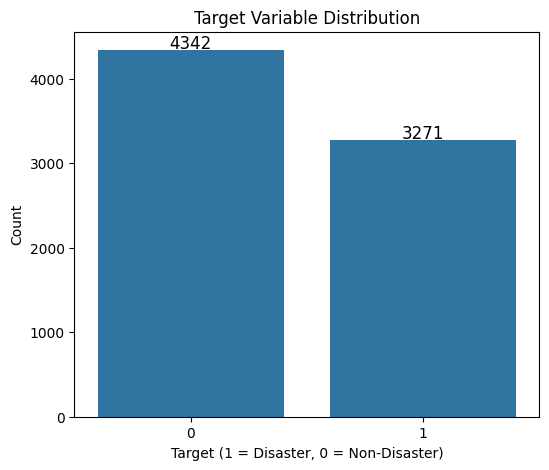

In [25]:
#Traget Distribution
plt.figure(figsize=(6, 5))
ax= sns.countplot(x='target', data=train)
plt.title('Target Variable Distribution')
plt.xlabel('Target (1 = Disaster, 0 = Non-Disaster)')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',(p.get_x() + p.get_width() / 2., p.get_height()),  
        ha='center',va='center',fontsize=12,color='black',xytext=(0, 5),textcoords='offset points')
        
plt.show()

It is slightly imbalanced between 2 classes but the difference is not that big so I do not think it will casue
any problem later when we predict with the test data set.

I am curious about the frequent words in the text which target = 1 (disaseter) and 0 (non-disaster).

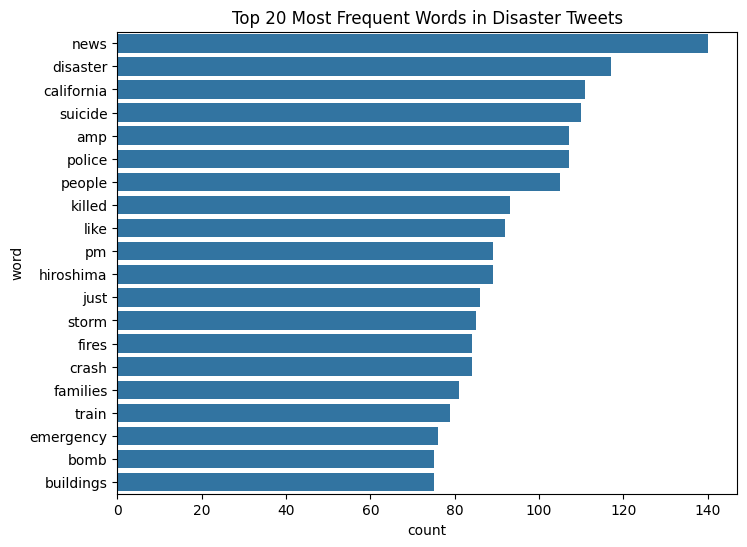

In [26]:
#Disaster tweets
disaster_tweets = train[train['target'] == 1]

# Tokenize words 
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_freq = vectorizer.fit_transform(disaster_tweets['clean_text'])
word_counts = word_freq.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Create a DataFrame 
word_df = pd.DataFrame(zip(words, word_counts), columns=['word', 'count'])
word_df = word_df.sort_values(by='count', ascending=False)

# Plot 
plt.figure(figsize=(8,6))
sns.barplot(x='count', y='word', data=word_df)
plt.title('Top 20 Most Frequent Words in Disaster Tweets')
plt.show()

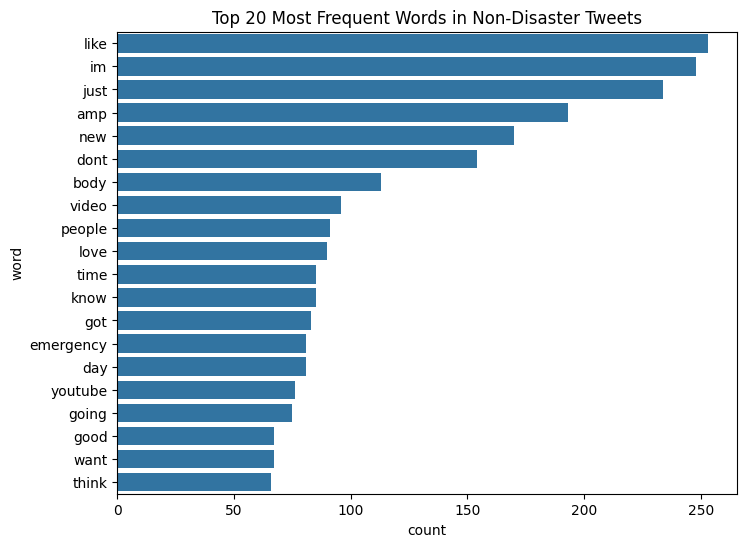

In [27]:
#Non-disaster tweets
nondisaster_tweets = train[train['target'] == 0]

# Tokenize words 
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_freq = vectorizer.fit_transform(nondisaster_tweets['clean_text'])
word_counts = word_freq.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Create a DataFrame 
word_df = pd.DataFrame(zip(words, word_counts), columns=['word', 'count'])
word_df = word_df.sort_values(by='count', ascending=False)

# Plot 
plt.figure(figsize=(8,6))
sns.barplot(x='count', y='word', data=word_df)
plt.title('Top 20 Most Frequent Words in Non-Disaster Tweets')
plt.show()

The frequent words in Non-disaster tweets seem reasonable. However, some frequent words in disaster tweets
can cause some confusion for the predicting model: "california", "like", and "just".

In my opinion, removing those 3 words from the text can imrove the accuracy.

In [28]:
#Removing 'california', 'like', and 'just' words in the clean_text
train['clean_text'] = train['clean_text'].str.replace(r'\b(california|like|just)\b', '', case=False, regex=True)

Let's check if those words have been removed.

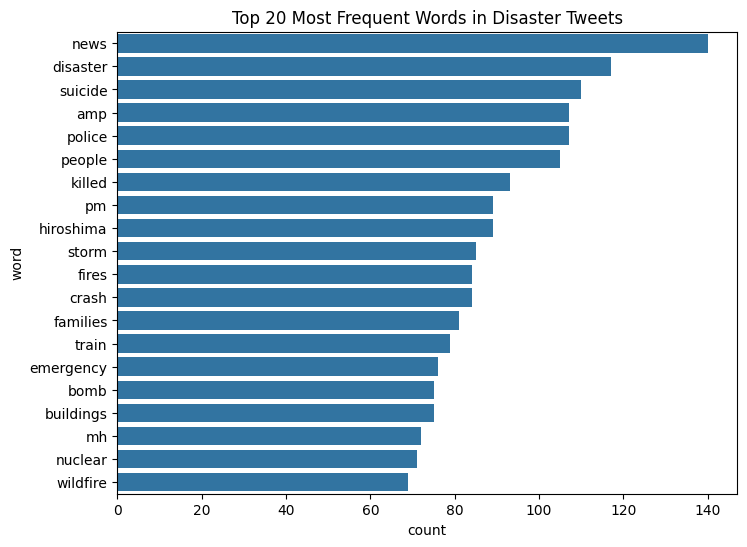

In [29]:
#Disaster tweets
disaster_tweets = train[train['target'] == 1]

# Tokenize words 
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_freq = vectorizer.fit_transform(disaster_tweets['clean_text'])
word_counts = word_freq.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Create a DataFrame 
word_df = pd.DataFrame(zip(words, word_counts), columns=['word', 'count'])
word_df = word_df.sort_values(by='count', ascending=False)

# Plot 
plt.figure(figsize=(8,6))
sns.barplot(x='count', y='word', data=word_df)
plt.title('Top 20 Most Frequent Words in Disaster Tweets')
plt.show()

Those 3 words had been removed.

Before building the model to classify either tweets are disaster-related(1) or non-disaster-related(0),
there is a step called word embedding which is basically converting the raw test into numerical representations.

I am choosing TF-IDF (Term Frequency-Inverse Document Frequency) this time because it works by assigning a weight to each
word based on its frequency in tweets.

In [30]:
#Word Embedding
vectorizer = TfidfVectorizer(stop_words = 'english', max_features=5000)
X = vectorizer.fit_transform(train['clean_text']).toarray()
y = train['target']

#Splitting train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

For the machine learning model, I am choosing bidirectional LSTMs because this model processes text
in both forward and backward directions, which allows the model to capture context from the past, future
and the surrounding words, thus improving its understanding sentence context.

In [47]:
#Bidirectional LSTMs
model = Sequential()

model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(X_train.shape[1], 1)))

#Dense layers for classification
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

/Users/jihyekim/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 256)            │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,633 (584.50 KB)

 Trainable params: 149,633 (584.50 KB)

 Non-trainable params: 0 (0.00 B)

ReLu is chosen as activation for the dense layer because it handles non-linear transformation effectively and 
compute gradients efficiently.

Sigmoid is chosen as activation for the output layer because it's binary classification.

In [40]:
#Train the Model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

#Evaluate the Model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy}')

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.5671 - loss: 0.6873 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step - accuracy: 0.5690 - loss: 0.6846 - val_accuracy: 0.5739 - val_loss: 0.6829
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 390s 4s/step - accuracy: 0.5595 - loss: 0.6875 - val_accuracy: 0.5739 - val_loss: 0.6821
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - accuracy: 0.5865 - loss: 0.6807 - val_accuracy: 0.5739 - val_loss: 0.6846
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.5697 - loss: 0.6851 - val_accuracy: 0.5739 - val_loss: 0.6821
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 603ms/step - accuracy: 0.5694 - loss: 0.6834
Validation Accuracy: 0.5738673806190491


After training the model with the training data set, the accuracy score is generated with the validation
data set. It is 0.57 which is not that great.

Let's try out simpler architecture.

In [54]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(128, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.summary()



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,961 (97.50 KB)

 Trainable params: 24,961 (97.50 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
#Train the Model
history_rnn = model_rnn.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

#Evaluate the Model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy}')

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 63s 654ms/step - accuracy: 0.5330 - loss: 0.6998 - val_accuracy: 0.4268 - val_loss: 0.6984
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 636ms/step - accuracy: 0.5362 - loss: 0.6944 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 62s 643ms/step - accuracy: 0.5707 - loss: 0.6860 - val_accuracy: 0.5739 - val_loss: 0.6828
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 634ms/step - accuracy: 0.5670 - loss: 0.6849 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 634ms/step - accuracy: 0.5656 - loss: 0.6866 - val_accuracy: 0.5739 - val_loss: 0.6822
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 565ms/step - accuracy: 0.5640 - loss: 0.6931
Validation Accuracy: 0.5692711472511292


Bidirectional LSTM and simple RNN's accuracy scores on the validation data set are not that different.
They are almost same, which means both of them are not that great. This can mean that Bidirectional LSTM may be too simple
to perform properly. 

I would like to try adding one more layer, which will make the model more complex, to the bidirectional LSTM model and see if this improves its performance.
Stacking LSTM layers can enhance model performance because each layer can learn features at different levels of dependencies and
patterns. Also, another layer can allow model to learn more complex representations which will lead to better generalization 
on unseen data.

In [57]:
#Bidirectional LSTM + one more LSTM layer
model_complex = Sequential()

model_complex.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model_complex.add(Bidirectional(LSTM(64, return_sequences=False)))

#Dense layers for classification
model_complex.add(Dense(64, activation='relu'))
model_complex.add(Dropout(0.5))

#Output layer
model_complex.add(Dense(1, activation='sigmoid'))

model_complex.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

model_complex.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 5000, 256)      │       133,120 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,793 (1.17 MB)

 Trainable params: 305,793 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
#Train the Model
history_complex = model_complex.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

#Evaluate the Model
loss, accuracy = model_complex.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy}')

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 969s 10s/step - accuracy: 0.5616 - loss: 0.6872 - val_accuracy: 0.5739 - val_loss: 0.6835
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1140s 12s/step - accuracy: 0.5739 - loss: 0.6834 - val_accuracy: 0.5739 - val_loss: 0.6828
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1123s 12s/step - accuracy: 0.5628 - loss: 0.6857 - val_accuracy: 0.5739 - val_loss: 0.6828
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1167s 12s/step - accuracy: 0.5605 - loss: 0.6879 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1132s 12s/step - accuracy: 0.5712 - loss: 0.6829 - val_accuracy: 0.5739 - val_loss: 0.6822
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5694 - loss: 0.6834
Validation Accuracy: 0.5738673806190491


The accuracy score on validation data set of more complex bidirectional LSTM model is same as the original
bidirectional LSTM model. Adding another LSTM layer did not help.

Based on this result, the models might be overfitting the training data. One of the solutions is increasing
the dropout rate which helps regularize the model.

In [63]:
#Hyperparameter tuning: different dropout rate
def create_model(dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=X_train.shape[1])) 
    model.add(Bidirectional(LSTM(128, return_sequences=False)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

dropout_rates = [0.6, 0.8, 0.9]

results = []

for rate in dropout_rates:
    print(f'Training model with dropout rate: {rate}')
    
    model = create_model(rate)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=5,  
                        batch_size=32,
                        callbacks=[early_stopping],
                        verbose=1)

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    results.append((rate, val_loss, val_accuracy))
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Training model with dropout rate: 0.6
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 920s 5s/step - accuracy: 0.5690 - loss: 0.6877 - val_accuracy: 0.5739 - val_loss: 0.6829
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1071s 6s/step - accuracy: 0.5784 - loss: 0.6841 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1071s 6s/step - accuracy: 0.5652 - loss: 0.6866 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1064s 6s/step - accuracy: 0.5514 - loss: 0.6889 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1075s 6s/step - accuracy: 0.5702 - loss: 0.6852 - val_accuracy: 0.5739 - val_loss: 0.6825
Validation Loss: 0.6822, Validation Accuracy: 0.5739
Training model with dropout rate: 0.8
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 903s 5s/step - accuracy: 0.5388 - loss: 0.6900 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1045s 5s/step - accuracy: 0.5641 - loss: 0.6885 - val_accura

Increasing the dropout rate did not really help. I even added early stopping, which is a regularization technique,
to prevent overfitting but did not improve the accuracy at all.

Instead of LSTM, let's try GRU with different dropout rate.

In [68]:
# Create a GRU-based model
def create_gru_model(dropout_rate):
    model = Sequential()
    
    model.add(GRU(128, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train and validate with different dropout rates
dropout_rates = [0.6, 0.8, 0.9]
results = []

for rate in dropout_rates:
    print(f'Training with dropout rate: {rate}')
    model = create_gru_model(rate)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
        epochs=5, batch_size=32, callbacks=[early_stopping], verbose=1)
    
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    results.append((rate, val_loss, val_accuracy))
    print(f'Validation Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}')

Training with dropout rate: 0.6
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 530s 3s/step - accuracy: 0.5712 - loss: 0.6865 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.5755 - loss: 0.6843 - val_accuracy: 0.5739 - val_loss: 0.6841
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.5594 - loss: 0.6868 - val_accuracy: 0.5739 - val_loss: 0.6821
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 505s 3s/step - accuracy: 0.5696 - loss: 0.6840 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.5612 - loss: 0.6864 - val_accuracy: 0.5739 - val_loss: 0.6823
Validation Accuracy: 0.5739, Loss: 0.6821
Training with dropout rate: 0.8
Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.5674 - loss: 0.6883 - val_accuracy: 0.5739 - val_loss: 0.6842
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.5627 - loss: 0.6862 - val_accuracy: 0.5739 - val_loss: 0.682

The process has been very slow like taking hours.

Now, I would like to use PyTorch tensors for faster process.

In [31]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

#RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1) 
        rnn_out, _ = self.rnn(x)
        out = self.fc(rnn_out[:, -1, :])
        return out

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y))
learning_rate = 0.001
num_epochs = 10

# Model, loss, and optimizer
model = SimpleRNN(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation accuracy
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(preds == y_batch).item()

    val_accuracy = val_correct / len(val_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/10, Loss: 110.6211, Validation Accuracy: 0.7853
Epoch 2/10, Loss: 68.7646, Validation Accuracy: 0.7899
Epoch 3/10, Loss: 53.0171, Validation Accuracy: 0.7754
Epoch 4/10, Loss: 43.4715, Validation Accuracy: 0.7735
Epoch 5/10, Loss: 36.7954, Validation Accuracy: 0.7623
Epoch 6/10, Loss: 31.9436, Validation Accuracy: 0.7571
Epoch 7/10, Loss: 28.4174, Validation Accuracy: 0.7459
Epoch 8/10, Loss: 25.4918, Validation Accuracy: 0.7511
Epoch 9/10, Loss: 22.9784, Validation Accuracy: 0.7518
Epoch 10/10, Loss: 21.0882, Validation Accuracy: 0.7360


The model processing is much faster with Pytorch tensor and validation accuracy is much higher now.

This NLP data set is more suitable with simple RNN rather than more complex bidirectional LSTM. Also, even more
complex model such as LSTM with more dense layer did not result the higher accuracy. Different drop out rate
with early stopping, which is regularization technique, did not improve the accuracy.

Using the DataLoader in Pytorch may have prevented the overfitting more efficiently than increasing the dropout
rates and adding early stopping, because DataLoader shuffles the data that makes model not to overfit to a specific 
sequence of batches.

I thought more batch size would be more effective so used 64 on the previous models but used 32 batch size on the 
last model and the result is better. It is because a smaller batch size can improve gradient updates, especially for
smaller datasets. I did not think 7600 rows in train dataset would be consdiered as smaller dataset but it could be
smaller dataset compare to other real world datasets.

Due to the processing time, I selected 5 for epochs but 10 for the last model. More epochs can improve the model because
the model can learn the patterns more fully.

Time to predict the Tweets text in the test data.

In [36]:
#Preprocessing just like the train dataset
test['text'] = test['text'].apply(preprocess_text)

#Removing 'california', 'like', and 'just' words in the test dataset
test['text'] = test['text'].str.replace(r'\b(california|like|just)\b', '', case=False, regex=True)

#Transform test data
X_test = vectorizer.transform(test['text']).toarray()

# Convert test data to PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader for the test set
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Ensure the model is in evaluation mode
model.eval()

# Predict the labels
predicted_labels = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch[0].to(device)  # Test DataLoader returns a tuple
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        predicted_labels.extend(preds.cpu().numpy())

# Add predicted labels to the test DataFrame
test['taget'] = predicted_labels

# Display the test DataFrame with the new column
print(test.head())

   id keyword location                                               text  \
0   0     NaN      NaN                      happened a terrible car crash   
1   2     NaN      NaN  heard about earthquake is different cities sta...   
2   3     NaN      NaN  there is a forest fire at spot pond geese are ...   
3   9     NaN      NaN              apocalypse lighting spokane wildfires   
4  11     NaN      NaN        typhoon soudelor kills  in china and taiwan   

   label  taget  
0      1      1  
1      1      1  
2      1      1  
3      1      1  
4      1      1  


In [39]:
submission = test[['id']].copy()
submission['target'] = predicted_labels

submission.to_csv('submission.csv', index=False)

print(submission.head())

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


Conclusion: In this project, I developed and evaluated multiple machine learning models to classify
tweet texts rather they are about non-disaster(0) or real disaster(1). First, I built a bidirectional LSTM model
but the validation accuracy was 0.57, which is lower than my expectation, so built simpler RNN using TF-IDF vectorizer
but the accuracy did not improve. Third model was bidirectional LSTM model but with one more LSTM layer, which is more
complex than the first model. I thought more complex model would learn the pattern in the dataset better and 
improve the validation accuracy but the result was same as before. After trying out all these, I tried out different
dropout rate because I thought there could be overfitting on the validation dataset so increasing the drop out rate
could help but the result was same. Instead of LSTM, also tried out GRU but the accuracy did not improve. Finally, the last
model that I built was simple RNN model using PyTorch. The LSTM and GRU were computaionally expensive and took so much time to run
but switching to PyTorch allowed the RNN model to run so mcuh faster and validation accuracy improved to around 0.77.
I thought complex and computationally more expensive models always work better for any dataset but I learned that I was wrong.
Those complex models can perform better with larger datasets but the dataset I had for this project was more suitable with
simpler RNN model.